<a href="https://colab.research.google.com/github/dhamvi01/Stacking-to-Choose-the-Best-Possible-Algorithm/blob/main/Best_Possible_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Step 1: Import all the libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error,r2_score
import math
import time
pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore')

#### Step 2: Load dataset

In [27]:
data = pd.read_csv('houseprices.csv')
print(data.shape)

(1460, 81)


Step 3: Data Engineering
Data needs to be engineered to handle:

Treat missing values
Categorical variables: Remove rare labels
Categorical variables encoding
Engineer temporal variables
Treat non-Gaussian distributed variables
Feature scaling

#### Train-Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data,data['SalePrice'],test_size=0.25,
                                                     random_state=0) 
X_train.shape, X_test.shape

((1095, 81), (365, 81))

1. Treat Missing values

In [29]:
vars_with_na = [var for var in data.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O']
for var in vars_with_na:
    # calculate the mode using the train set
    mode_val = X_train[var].mode()[0]
    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)

2. Categorical-Removing rare labels

In [30]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)['SalePrice'].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

3. Categorical variable encoding

In [31]:
def replace_categories(train, test, var, target):
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

for var in cat_vars:
    replace_categories(X_train, X_test, var, 'SalePrice')

4. Engineer temporal variables

In [32]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

5. Treat non-gaussian distributed variables

In [33]:
for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

6. Feature Scaling

In [34]:
train_vars = [var for var in X_train.columns if var not in ['Id', 'SalePrice']]
# create scaler
scaler = MinMaxScaler()
#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 
# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])
print(X_train.isnull().sum().any(),X_test.isnull().sum().any())

False False


Step 4: Feature Selection

In [35]:
y_train = X_train['SalePrice']
y_test = X_test['SalePrice']
# drop unnecessary variables from our training and testing sets
X_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
X_test.drop(['Id', 'SalePrice'], axis=1, inplace=True)

In [36]:
sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features
selected_feats = X_train.columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 79
selected features: 25
features with coefficients shrank to zero: 54


Step 5: Build models

In [37]:
X_train=X_train[selected_feats]
X_test=X_test[selected_feats]
print(X_train.shape,X_test.shape)

(1095, 25) (365, 25)


In [38]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

Step 6: Compare the performance 

In [39]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True_Price')
    ax.set_ylabel('Predicted_Price')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + 'n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

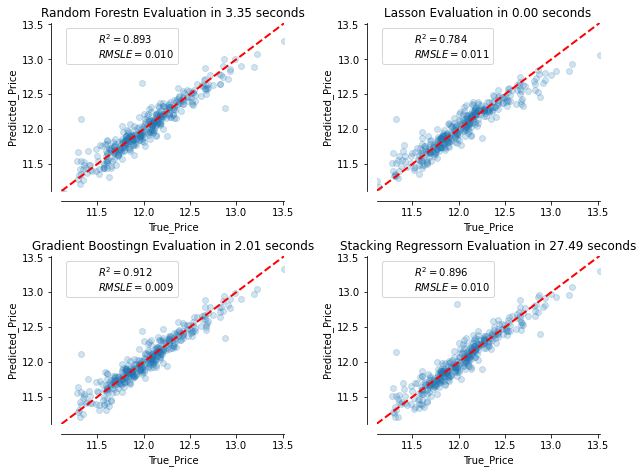

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    model = est.fit(X_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(X_test)
    errors = y_test - model.predict(X_test)
    errors_list.append(errors)
    test_r2= r2_score(np.exp(y_test), np.exp(pred))
    
    test_rmsle=math.sqrt(mean_squared_log_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(r'$R^2={:.3f}$' + '\n' + 
                            r'$RMSLE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()